#### Aside from loading a single file, the reader scripts allow one to specify any start time / end time, and will return a single block of data from multiple files as needed. Optionally, one can also specify start- and end-distances, and only the needed channels will be loaded.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("./")
from pydas_readers.readers import load_das_h5, write_das_h5
from pydas_readers.util import block_filters





# Load Data

In [5]:
#############################################
#-- Option 1: Specify an H5 file by name (as in "0_simplest_example.ipynb"):
data, headers, axis = load_das_h5.load_file('./example_data_Athens/data_raw_epoch2/2021_10_12/athens_50Hz_20211012_092408.401083.h5')


t0 = headers['t0']
t1 = headers['t1']
lx = headers['lx']
print(" ")
print("--- Data: ---")
print("\"data\" array: [{0} x {1}]".format(np.shape(data)[0], np.shape(data)[1]))
print("              (npts x nchan)")
print("--- Headers: ---")
print("Sample rate:     {0}".format(headers['fs']))
print("Channel spacing: {0}".format(headers['dx']))
print("Total Length:    {0}".format(headers['lx']))
print("Data units:      {0}".format(headers['unit']))
print("File start time: {0}".format(headers['t0'].strftime('%Y.%m.%d %H:%M:%S.%f')))
print("File end time:   {0}".format(headers['t1'].strftime('%Y.%m.%d %H:%M:%S.%f')))
print("etc...")
print("--- Axis: ---")
print("\"dd\" array of distances:     [{0}] (distance of each channel, in meters)".format(np.shape(axis['dd'])))
print("\"tt\" array of timesamples:   [{0}] (relative to 0 seconds)".format(np.shape(axis['tt'])))
print("\"date_times\" array of times: [{0}] (absolute UTC times)".format(np.shape(axis['date_times'])))
#############################################


 
--- Data: ---
"data" array: [1500 x 12416]
              (npts x nchan)
--- Headers: ---
Sample rate:     50
Channel spacing: 2
Total Length:    24832
Data units:      (nm/m)/s * Hz/m
File start time: 2021.10.12 09:24:08.401083
File end time:   2021.10.12 09:24:38.398583
etc...
--- Axis: ---
"dd" array of distances:     [(12416,)] (distance of each channel, in meters)
"tt" array of timesamples:   [(1500,)] (relative to 0 seconds)
"date_times" array of times: [(1500,)] (absolute UTC times)


In [6]:
#############################################
#-- Option 2: Specify a start-time and end-time, start-distance and end-distance, etc.
#--   The script will look in a given directory. 
#--   And within that, can also look for directories organized by day (e.g., /2021_09_27/*h5)
#--   or by epoch. (Script looks for directories formatted like YYYY_MM_DD, or for keyword "epoch")
#--   To handle different organizations, the script will need to be modified.
print("-----------------------")
print("Loading a custom time window from multiple files:")


#-- Specify a start time and end time with Datetime objects
t_start = datetime(2021,9,27,10,49,20)
#-- or --
t_start = datetime.strptime('2021/10/12 09:24:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2021/10/12 09:25:40.0', '%Y/%m/%d %H:%M:%S.%f') 


#-- Load!
input_dir = "./example_data_Athens/data_raw_epoch2/"
data, headers, axis = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, verbose=False)




#############################################
# #-- Can optionally also specify distances in meters
# d_start = 300
# d_end   = 1000


# data, headers, axis = load_das_h5.load_das_custom(
#         t_start, t_end, verbose=False, 
#         d_start=d_start, d_end=d_end,
#         input_dir=input_dir)
#############################################


t0 = headers['t0']
t1 = headers['t1']
lx = headers['lx']
print(" ")
print("--- Data: ---")
print("\"data\" array: [{0} x {1}]".format(np.shape(data)[0], np.shape(data)[1]))
print("              (npts x nchan)")
print("--- Headers: ---")
print("Sample rate:     {0}".format(headers['fs']))
print("Channel spacing: {0}".format(headers['dx']))
print("Total Length:    {0}".format(headers['lx']))
print("Data units:      {0}".format(headers['unit']))
print("File start time: {0}".format(headers['t0'].strftime('%Y.%m.%d %H:%M:%S.%f')))
print("File end time:   {0}".format(headers['t1'].strftime('%Y.%m.%d %H:%M:%S.%f')))
print("etc...")
print("--- Axis: ---")
print("\"dd\" array of distances:     [{0}] (distance of each channel, in meters)".format(np.shape(axis['dd'])))
print("\"tt\" array of timesamples:   [{0}] (relative to 0 seconds)".format(np.shape(axis['tt'])))
print("\"date_times\" array of times: [{0}] (absolute UTC times)".format(np.shape(axis['date_times'])))
#############################################


-----------------------
Loading a custom time window from multiple files:
 
--- Data: ---
"data" array: [4501 x 12416]
              (npts x nchan)
--- Headers: ---
Sample rate:     50
Channel spacing: 2
Total Length:    24832
Data units:      (nm/m)/s * Hz/m
File start time: 2021.10.12 09:24:10.001083
File end time:   2021.10.12 09:25:40.001083
etc...
--- Axis: ---
"dd" array of distances:     [(12416,)] (distance of each channel, in meters)
"tt" array of timesamples:   [(4501,)] (relative to 0 seconds)
"date_times" array of times: [(4501,)] (absolute UTC times)


### Note: 
There is also a function load_headers_only(), which is used by the custom reader.
This is the advantage of HDF5 files: we can quickly load headers without touching the block of data,
*then* decide which indices to load from which files

# Example Pre-processing

In [7]:
#-- Downsample
print("-----------------------")
print("Preprocessing and plotting")
fs = headers['fs']
t0 = headers['t0']

#-- The example data here has already been downsampled to 50Hz, so no further downsampling is needed
#-- but here is how one might do this:
downsample_factor = 1
if(downsample_factor > 1):
    data2 = block_filters.chebychev_lowpass_downsamp(data,fs,downsample_factor)

    # Redo tt and datetimes accordingly
    tt = np.arange(0, np.shape(data2)[0]/fs*downsample_factor, 1.0/fs*downsample_factor) 
    date_times = [None]*len(tt)
    for i,t in enumerate(tt):
        #date_times.append((final_t0+t)._get_datetime())
        date_times[i] = t0 + timedelta(seconds=t)
        
    headers['fs'] = fs/downsample_factor
    headers['fs_orig'] = fs
    headers['npts'] = np.shape(data2)[0]
    headers['nchan'] = np.shape(data2)[1]
else:
    data2 = data.copy()
    downsample_factor = 1 # set to one for later divide-by-zero issues
    

    
#-- Bandpass Filter
f1 = 0.1
f2 = 15.0
data3 = block_filters.block_bandpass(data2, f1, f2, fs/downsample_factor, zerophase=False)
print("   Filtering completed")


#############################################


-----------------------
Preprocessing and plotting
   Filtering completed


# Quick plot

-----------------------
Making a plot


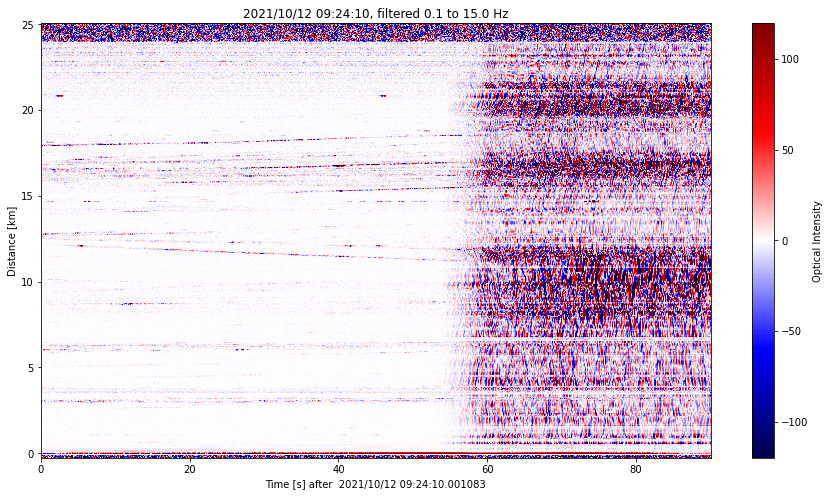

In [8]:
print("-----------------------")
print("Making a plot")
dx = headers['dx']
fm = headers['fm']
d0 = headers['d0']
fs = headers['fs']

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(15,8))
ax = plt.gca()

plt.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
        extent=(0,headers["npts"]/headers["fs"], headers["d1"]/1000,headers["d0"]/1000),
        vmin=-120, vmax=120)

plt.colorbar(label="Optical Intensity")
plt.xlabel("Time [s] after  "+ datetime.strftime(headers["t0"], format='%Y/%m/%d %H:%M:%S.%f'))
plt.ylabel("Distance [km]")
plt.title("{0}, filtered {1} to {2} Hz".format(headers["t0"].strftime('%Y/%m/%d %H:%M:%S'),f1,f2))
ax.invert_yaxis()

# plt.savefig("example_figure.png",bbox_inches="tight")
plt.show()





# Save a new data file
Maybe you've downsampled, or queried a custom time-window and want to save a new file?

In [9]:
#############################################

print("-----------------------")
print("Saving a new file")

save_dir = "./example_data_processed/"
new_filename = "{0}/athens_example_{1}.h5".format(save_dir, t0.strftime('%Y%m%d_%H%M%S.%f'))
print(new_filename)

#-- If you've downsampled, remember to update fs
# fs = fs/downsample_factor 

write_das_h5.write_block(data2,headers,new_filename)

#############################################


-----------------------
Saving a new file
./example_data_processed//athens_example_20211012_092410.001083.h5


# Convert to an OBSPY Stream for further tools

-----------------------
Converting to OBSPY Stream
12416 Trace(s) in Stream:

DAS.D0000..STR | 2021-10-12T09:24:10.001083Z - 2021-10-12T09:25:40.001083Z | 50.0 Hz, 4501 samples
...
(12414 other traces)
...
DAS.D12415..STR | 2021-10-12T09:24:10.001083Z - 2021-10-12T09:25:40.001083Z | 50.0 Hz, 4501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


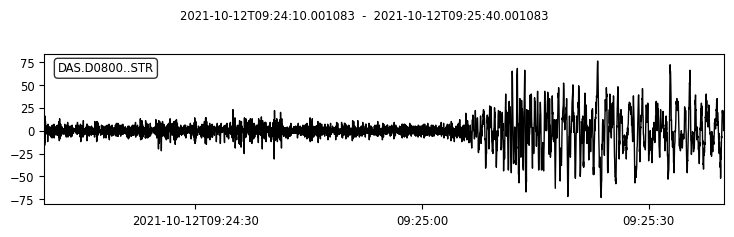

In [10]:
print("-----------------------")
print("Converting to OBSPY Stream")

from obspy.core import UTCDateTime
import obspy

#-- Convert to Stream object
Nchannels = np.shape(data2)[1]
npts  = np.shape(data2)[0]

trace_l = (("sampling_rate", fs),
       ("delta", 1. / fs),
       ("calib", 1.),
       ("npts", npts),
       ("network", "DAS"),
       ("station", ""),
       ("starttime", UTCDateTime(t0))
       )

trace_dict = {key: value for (key, value) in trace_l}

st = obspy.Stream()
for i in range(Nchannels):
    tr = obspy.Trace(data=data2[:, i], header=trace_dict.copy())
    tr.stats.distance = axis['dd'][i]
    tr.stats.channel = "STR"
    tr.stats.station = "D" + "{0:04d}".format(i)
    st+=tr
    
print(st)
st[800].plot()
plt.show()